# Visualization of experimental data

From Fox et al. 2018 - https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018GL077951

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from he_utilities import set_matplotlib_customization
set_matplotlib_customization(plt)

### Import colormap to match experimental with numerical results

In [3]:
import json
from matplotlib.colors import ListedColormap

with open("./miscellaneous/colorscale.json") as f:
    json_cmap = json.load(f)

jsonmap = json_cmap[0]["RGBPoints"]

points = jsonmap[::4]
red = jsonmap[1::4]
green = jsonmap[2::4]
blue = jsonmap[3::4]

rgb = [[r,g,b,1.0] for r,g,b in zip(red, green, blue)]
deposited_clay_cmap = ListedColormap(rgb)

### Read experimental data 

In [4]:
data = pd.read_excel("./miscellaneous/FoxHeatmapData.xlsx")
z = data.set_index("Depth").to_numpy()   #Percent content of clay

## Data conversion

Experimental data for clay deposition was reported as a mass percentage between clay and sand.

$$
    \textsf{\% clay} = \dfrac{m_\textsf{deposited clay}}{m_\textsf{sand}} = \dfrac{S}{\rho_\textsf{sand}(1-n_0)}
$$

With the sand density $\rho_\textsf{sand} = 1500 \, {\rm kg/m^3}$ and initial porosity $n_0 = 0.35$.

In [5]:
ρ_sand = 1500 # Density of loose sand [kg/m³]
initial_porosity = 0.35
deposited_clay = ρ_sand * z/100 * (1 - initial_porosity)

### Reposition coordinates of experiment to match the simulations origin

In [6]:
## Shape from the experimental data
depth = data["Depth"].to_numpy()/100.0  # m
length = np.array([float(x) for x in data.columns[1:]])/100.0  #m

## Shape from the numerical model
shapeDune = pd.read_csv("./miscellaneous/shapeOfDune.csv")
shapeDune = shapeDune[shapeDune["Points:2"] < 0.1][["Points:0", "Points:1", "Points:2"]]
shapeDune.sort_values(['Points:0', 'Points:2'], inplace=True)

shape_x = shapeDune['Points:0'].to_numpy()[:-1]
shape_y = shapeDune['Points:1'].to_numpy()[:-1]

In [7]:
## Organize

imin = np.argmin(shape_y)

shape_y = np.concatenate([
    shape_y[imin:],
    shape_y[:imin]
])

shape_y -= shape_y.max()

## Draw
from collections import namedtuple
Line = namedtuple("Line", ["x", "y"])
duneline = Line(x=[0, 0.10, 0.15], y=[-0.015, 0, -0.015])

## Figure 3c

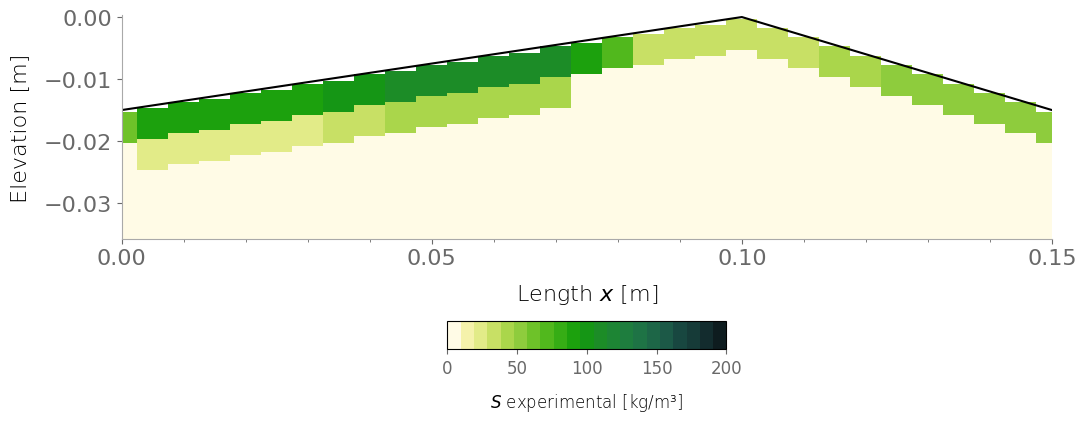

In [10]:
from matplotlib.ticker import MaxNLocator

xx,yy = np.meshgrid(length, depth)

fig,ax = plt.subplots(figsize=(12,12))
img = ax.pcolormesh(xx, yy, deposited_clay, cmap=deposited_clay_cmap, vmax=200, vmin=0)
cb = fig.colorbar(img, shrink=0.3, orientation="horizontal", pad=-0.15, anchor=(0.5, -1.0), aspect=10)
ax.set_aspect("equal")

cb.ax.set_xlabel("$S$ experimental [kg/m³]")
ax.plot(duneline.x, duneline.y, c="k")
ax.set_xlim(0, 0.15)

ax.set_xlabel("Length $x$ [m]", fontsize=16)
ax.xaxis.set_major_locator(MaxNLocator(3))
ax.xaxis.set_minor_locator(MaxNLocator(16))
ax.tick_params(labelsize=16)

ax.set_ylabel("Elevation [m]", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('darkgray')
ax.spines['bottom'].set_color('darkgray')
ax.set_facecolor("#ffffff00")
fig.set_facecolor("#ffffff")

plt.savefig("experimentalFox.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()

### Total deposited clay
**Experimental $m_S$**

$$
    m_S = \dfrac{1}{w\lambda}\sum{S dV} = \dfrac{1}{\lambda}\sum{S dA}
$$

In [9]:
bed_wavelenght = 0.15 #m
dArea_experimental = 0.05/100 * 0.5/100  #m²
tot_mass_experimental = np.nansum(deposited_clay * dArea_experimental)/bed_wavelenght

print(f"Total mass of deposited clay at the end of experiment: {tot_mass_experimental:.3f} kg/m²")

Total mass of deposited clay at the end of experiment: 0.452 kg/m²
